In [1]:
import os
import glob

import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from model import MSResNet

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
shot_types = 9
other_metrics = 1
total_metics = 10

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
path = "data/"

In [238]:
X_data = []
y_data = [] 
for i in range(100):
    for csv in glob.glob(path + "*.csv"):
        x = pd.read_csv(csv).drop(columns="Unnamed: 0")
        y = np.zeros(total_metics)
        y[x["shot_type"][0]] = 1
        y[-1] = x["distance"][0]
        x_values = x.values[:, :-2].T + np.random.random(x.values[:, :-2].T.shape)
        X_data.append(x_values)
        y_data.append(y)

In [239]:
class SwingDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        super().__init__()
        self.X_data = torch.Tensor(X_data)
        self.y_data = torch.Tensor(y_data)
        
    def __len__(self):
        return self.X_data.shape[0]
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [240]:
swing = SwingDataset(X_data, y_data)

In [241]:
swing.y_data.shape

torch.Size([100, 10])

In [249]:
val_ratio = 0.1
val_size = int(len(swing)*val_ratio)
indices_val = list(range(0, val_size))
indices_train = list(range(val_size, len(swing)))

val_set = torch.utils.data.Subset(swing, indices_val)
train_set = torch.utils.data.Subset(swing, indices_train)

In [250]:
train_set.dataset.X_data.shape

torch.Size([100, 6, 2285])

In [251]:
val_set.dataset.X_data.shape

torch.Size([100, 6, 2285])

In [214]:
train_mean = train_set.dataset.X_data.mean(axis=0)
train_std = train_set.dataset.X_data.std(axis=0)

In [215]:
train_std

tensor([[3.0170, 3.3568, 3.4841,  ..., 6.4074, 5.3766, 3.9305],
        [3.6188, 3.5273, 4.7152,  ..., 3.0307, 4.2516, 3.0500],
        [3.8793, 2.8296, 3.3266,  ..., 2.8132, 2.7921, 3.0823],
        [2.9310, 3.4961, 2.6510,  ..., 3.5152, 3.1644, 3.2864],
        [3.4118, 4.1567, 3.8075,  ..., 3.3437, 3.3566, 2.9329],
        [5.2120, 3.8428, 3.5276,  ..., 2.9273, 5.5194, 3.7395]])

In [216]:
train_set.dataset.X_data.mean()

tensor(-6.4494)

In [225]:
train_mean = train_set.dataset.X_data.mean(axis=0)
train_std = train_set.dataset.X_data.std(axis=0)

In [228]:
train_set.dataset.X_data -= train_mean
train_set.dataset.X_data /= train_std

val_set.dataset.X_data -= train_mean
val_set.dataset.X_data /= train_std

In [227]:
train_set.dataset.X_data.mean(axis=0)

tensor([[-7.4506e-09,  1.4901e-08, -7.4506e-09,  ...,  3.7253e-09,
          0.0000e+00, -3.7253e-09],
        [-7.4506e-09, -7.4506e-09,  1.4901e-08,  ...,  0.0000e+00,
         -3.7253e-08,  7.4506e-09],
        [-1.4901e-08, -1.4901e-08, -2.9802e-08,  ..., -1.4901e-08,
         -1.4901e-08,  1.4901e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.3039e-08,
          0.0000e+00,  0.0000e+00],
        [-7.4506e-09, -7.4506e-09, -2.9802e-08,  ...,  0.0000e+00,
         -1.4901e-08,  0.0000e+00],
        [-8.1491e-09, -2.2352e-08,  0.0000e+00,  ...,  1.4901e-08,
         -7.4506e-09,  1.9558e-08]])

In [231]:
val_set.dataset.X_data.std(axis=0)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [74]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=4,
                                           shuffle=True, drop_last=False)


In [120]:
class BadModel(nn.Module):

    def __init__(self, num_conv_outer, num_conv_inner, ksize, 
                 num_hidden=1, num_unit=100, nchannel_base=6, num_class=10):
        super(BadModel, self).__init__()
        
        indim = 6
        cur_w = 2285
        
        self.Conv1d = nn.Conv1d
        self.Activation = nn.ReLU
        self.num_hidden = num_hidden
        self.Pool1d = nn.MaxPool1d
        self.Linear = nn.Linear
        self.num_conv_outer = num_conv_outer
        self.num_conv_inner = num_conv_inner
        
        outdim = None
        for _i in range(num_conv_outer):
            outdim = nchannel_base * 2 ** _i
            for _j in range(num_conv_inner):
                setattr(self, f"conv_conv1d_{_i}_{_j}", self.Conv1d(indim, outdim, ksize))
                setattr(self, f"conv_relu_{_i}_{_j}", self.Activation())
                cur_w = (cur_w - ksize) + 1
                indim = outdim

            setattr(self, f"conv_pool_{_i}", self.Pool1d(2, 2))
            cur_w = (cur_w - 2) // 2 + 1

        indim = outdim * cur_w
        for _i in range(num_hidden):
            outdim = num_unit
            setattr(self, f"fc_linear_{_i}", self.Linear(indim, outdim))
            setattr(self, f"fc_relu_{_i}", self.Activation())
            indim = outdim
            
        self.output = nn.Linear(indim, num_class)
        self.softmax = nn.Softmax()

        print(self)
        
    def forward(self, x):
        for _i in range(self.num_conv_outer):
            for _j in range(self.num_conv_inner):
                x = getattr(self, f"conv_conv1d_{_i}_{_j}")(x)
                x = getattr(self, f"conv_relu_{_i}_{_j}")(x)
            x = getattr(self, f"conv_pool_{_i}")(x)

        # Flatten
        x = x.view(x.shape[0], -1)
        
        # Apply the fully connected layers
        for _i in range(self.num_hidden):
            x = getattr(self, "fc_linear_{}".format(_i))(x)
            x = getattr(self, "fc_relu_{}".format(_i))(x)
        x = self.output(x)

        # softmax on the swing type classes
        swing_type = self.softmax(x[:,:-1])
        
        # concatenate back with the distance regression
        x= torch.cat([swing_type, x[:,-1:]], axis=1)
        
        return x

In [143]:
bestmodel_file = os.path.join("weights", "best_model.pth")

model = BadModel(5, 1, 3)
# model = MSResNet(input_channel=6, num_classes=10)

swing_type_loss = nn.BCELoss()
distance_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
va_losses = []
num_epochs = 10
iter_idx = -1
best_va_loss = 9999 
val_interval = 50
report_interval = 10

BadModel(
  (conv_conv1d_0_0): Conv1d(6, 6, kernel_size=(3,), stride=(1,))
  (conv_relu_0_0): ReLU()
  (conv_pool_0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_conv1d_1_0): Conv1d(6, 12, kernel_size=(3,), stride=(1,))
  (conv_relu_1_0): ReLU()
  (conv_pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_conv1d_2_0): Conv1d(12, 24, kernel_size=(3,), stride=(1,))
  (conv_relu_2_0): ReLU()
  (conv_pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_conv1d_3_0): Conv1d(24, 48, kernel_size=(3,), stride=(1,))
  (conv_relu_3_0): ReLU()
  (conv_pool_3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_conv1d_4_0): Conv1d(48, 96, kernel_size=(3,), stride=(1,))
  (conv_relu_4_0): ReLU()
  (conv_pool_4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_linear_0): Linear(in_features=6624, out_features=100, bias=Tru

In [147]:
loss_history = []
epochs = 10
for e in range(epochs):
    prefix = "Epoch {:3d}: ".format(e)
    for data in tqdm(train_loader, desc=prefix):
#     for data in train_loader:
        iter_idx += 1
        X_train, y = data
        X_train = X_train.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_train.float())
        
        swing_loss = swing_type_loss(outputs[:, :-1], y[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y[:, -1:])
        loss = swing_loss + dist_loss
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())

Epoch   0:   0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-120-26b3bfefb6e0>:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  swing_type = self.softmax(x[:,:-1])
Epoch   9: 100%|██████████| 1/1 [00:00<00:00, 43.38it/s]


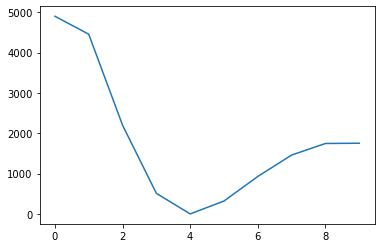

In [150]:
plt.plot(loss_history)